In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os, sys
import matplotlib as mpl
import healpy as hp
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
import pickle

from importlib import reload

mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots.mplstyle')
mpl.rcParams['axes.linewidth'] = 2.
mpl.rcParams['figure.dpi'] = 120

import sensitivity_fit_functions as sff

import seaborn as sns
palette = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f']

In [4]:
reload(sff)

<module 'sensitivity_fit_functions' from '/mnt/lfs7/user/apizzuto/fast_response_skylab/alert_event_followup/cascade_scripts/sensitivity_fit_functions.py'>

# First, calculate sensitivities vs. dec for different time windows

In [ ]:
sens_cols = [sns.xkcd_rgb['navy blue'], sns.xkcd_rgb['navy green'], sns.xkcd_rgb['deep magenta']]
disc_cols = [sns.xkcd_rgb['light navy blue'], sns.xkcd_rgb['lighter green'], sns.xkcd_rgb['light magenta']]

delta_ts = np.array([1000., 2*86400.])
sensitivities = np.zeros((2, 16))
discoveries = np.zeros((2, 16))

for jj, delta_t in enumerate(delta_ts[:]):
    casc_calc = sff.CascadeCalculator(delta_t)
    sensitivities[jj], discoveries[jj] = casc_calc.find_all_sens(disc_conf=0.5,
        disc_thresh=1.-0.0013, verbose=False)
    
decs_by_ind = casc_calc.cascade_info['dec'][::4]

Next, load the ideal sensitivity for a point source using Tessa's sample (ps_tracks_v003_p02). We will reference this line in our plots

In [ ]:
time_labels = [r'$10^3$ s', '2 days']

time_integrated = {'sens': [], 'disc': [], 'sinDec': []}
sinDecs = np.linspace(-0.95, 0.95, 39)
decs = np.arcsin(sinDecs) * 180. / np.pi
for dec in decs[:]:
    try:
        with open('/data/user/apizzuto/fast_response_skylab/fast-response/fast_response/combined_tracks_2.5/results/EstSens_PointSourceTracks_v003p00_10yrs_dec_{:.2f}_degrees.pickle'.format(dec), 'rb') as f:
            data = pickle.load(f, encoding='latin1')
    except Exception as e:
        try:
            with open('/data/user/apizzuto/fast_response_skylab/fast-response/fast_response/combined_tracks_2.5/results/EstSens_PointSourceTracks_v003p00_10yrs_dec_{:.1f}_degrees.pickle'.format(dec), 'rb') as f:
                data = pickle.load(f, encoding='latin1')
        except Exception as e:
            print(e)
    time_integrated['sens'].append(data['sensitivity_flux'])
    time_integrated['disc'].append(data['discovery_flux'])
    time_integrated['sinDec'].append(np.sin(dec * np.pi / 180.))
    
time_integrated['sens'] = np.array(time_integrated['sens'])
time_integrated['disc'] = np.array(time_integrated['disc'])

## Now, make some plots

We will, in addition to comparing to Tessa's analysis, also compare to the fast response analysis sensitivities for a perfectly localized point source (as opposed to using the skymap procedure we use)

In [ ]:
for ii, delta_t in enumerate(delta_ts[:]):
    try:
        fig = plt.figure(dpi=200)
        fig.set_facecolor('white')
        with open('/data/user/apizzuto/fast_response_skylab/dump/ideal_ps_sensitivity_deltaT_{:.2e}_50CL.pkl'.format(delta_t / 86400.), 'rb') as f:
            ideal = pickle.load(f, encoding='latin1')
        msk = sensitivities[ii]*delta_t*1e6 < 1e2
        plt.scatter(np.sin(decs_by_ind)[msk], sensitivities[ii][msk]*delta_t*1e6, 
                    color=sens_cols[ii], 
                    marker='^', label = 'Alert sensitivity', s=30)
        plt.scatter(np.sin(decs_by_ind)[msk], discoveries[ii][msk]*delta_t*1e6, 
                    color=sens_cols[ii], 
                    marker='2', linestyle='--', label = 'Alert discovery', s=30)
        
        plt.plot(ideal['sinDec'], np.array(ideal['sensitivity'])*delta_t*1e6, lw=3, ls='-', 
                 color=sens_cols[ii], label = 'P.S. sensitivity', alpha=0.7)
        plt.plot(ideal['sinDec'], np.array(ideal['discovery'])*delta_t*1e6, lw=3, ls='--', 
                 color=sens_cols[ii], label = r'P.S. $3\sigma$ discovery' +'\n\t(50\% CL)', 
                 alpha=0.7)
        plt.plot(time_integrated['sinDec'], time_integrated['sens'] * 86400. * 10. * 365. * 1e6,
                color = sns.xkcd_rgb['light grey'],
                alpha = 0.7, ls='-')
        plt.plot(time_integrated['sinDec'], time_integrated['disc'] * 86400. * 10. *365.* 1e6, 
                color = sns.xkcd_rgb['light grey'],
                alpha = 0.7, ls='--')

        plt.grid(which='both', alpha=0.2, zorder=1)
        plt.yscale('log')
        plt.legend(loc=1, ncol=1, frameon=True, fontsize=14) #columnspacing=0.6, frameon=False)
        #plt.loglog()
        plt.xlabel(r'$\sin \delta$')
        plt.title(r'$\Delta T = $' + time_labels[ii])
        plt.ylabel(r'$E^2 \frac{dN_{\nu+\bar{\nu}}}{dEdA} \Big|_{\mathrm{1 TeV}}$ (GeV cm$^{-2}$)')
        plt.ylim(3e-2, 3e2)
        plt.text(0.03, 1e0, '10 yr. time-integrated', color = sns.xkcd_rgb['light grey'])
        #plt.xlim(5e0, 1.5e7)
    except Exception as e:
        print(e)
    plt.show()

# Background Trial Panel Plots

The first plots were fairly high level. Now, take a step back and look at distributions and fitting plots

In [ ]:
bins = np.linspace(0., 20., 21)

for delta_t in [1000., 86400.*2.]:
    casc_calc = sff.CascadeCalculator(delta_t)
    bg = np.array(casc_calc.background_distribution(4))
    plt.hist(bg, bins=bins, histtype='step', lw=2.)

    plt.yscale('log')
    plt.xlabel('TS')
    plt.ylabel('$N$')
    #plt.legend()
    plt.title(r'$\Delta T = $' + f'{casc_calc.delta_t} seconds')

    plt.show()

In [ ]:
bins = np.linspace(0., 20., 21)

for delta_t in np.array([1000., 2.*86400.]):
    fig, aaxs = plt.subplots(ncols=4, nrows=4, figsize=(13,10), 
                            sharey=True, sharex=True)
    used_axs = []
    axs = aaxs.ravel()
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    casc_calc = sff.CascadeCalculator(delta_t)
    for ind in range(0, 62, 4):
        if ind == 44:
            continue
        plt_ind = ind//4
        if ind > 43:
            plt_ind -= 1
        try:
            bg = np.array(casc_calc.background_distribution(ind))
            axs[plt_ind].hist(bg, bins=bins, histtype='step', lw=2.)
            
            axs[plt_ind].set_yscale('log')
            axs[plt_ind].set_ylim(0.8e0, 2e4)
            
            if plt_ind // 4 == 3:
                axs[plt_ind].set_xlabel('TS')
            if plt_ind % 4 == 0:
                axs[plt_ind].set_ylabel('$N$')
            used_axs.append(axs[plt_ind])
        except (IOError, ValueError, IndexError) as err:
            pass
    for ax in axs:
        if ax not in used_axs:
            ax.set_visible(False)
    fig.suptitle(r'$\Delta T = $' + '{:.1e} s'.format(delta_t), y=0.92)
    plt.show()

# Fit validation panel plots

In [ ]:
delta_t = 1000.
casc_calc = sff.CascadeCalculator(delta_t)
casc_calc.ns_fits_contours_plot(12, show=False, legend=True)
plt.xlim(0., 11)
plt.ylim(0., 11.)

In [ ]:
for delta_t in np.array([1000., 2.*86400.]):
    fig, aaxs = plt.subplots(ncols=4, nrows=4, figsize=(13,10), 
                            sharey=True, sharex=True)
    used_axs = []
    axs = aaxs.ravel()
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    casc_calc = sff.CascadeCalculator(delta_t)
    for ind in range(0, 62, 4):
        if ind == 44:
            continue
        plt_ind = ind//4
        if ind > 43:
            plt_ind -= 1
        xlab = plt_ind // 4 == 3
        ylab = plt_ind % 4 == 0 
        try:
            casc_calc.ns_fits_contours_plot(ind, show=False,
                ax=axs[plt_ind], xlabel=xlab, ylabel=ylab, legend=False)
            used_axs.append(axs[plt_ind])
        except (IOError, ValueError, IndexError) as err:
            print(err)
    for ax in axs:
        if ax not in used_axs:
            ax.set_visible(False)
    fig.suptitle(r'$\Delta T = $' + '{:.1e} s'.format(delta_t), y=0.93)
    plt.show()

In [ ]:
legend_elements = [Line2D([0], [0], color='gray', ls='--', label='Injected'),
                   Line2D([0], [0], marker='x', color='gray', label='Fit (50\% cont.)', ls='')]

for delta_t, delta_t_str in zip([1000., 172800.], 
        [r'$\Delta T = 10^3$ s', r'$\Delta T = 1.7\times 10^5$ s']):
    casc_calc = sff.CascadeCalculator(delta_t)
    bias, spread = casc_calc.fitting_bias_summary()
    for ii, sig in enumerate([2.0, 5.0]):
        msk = np.array(bias[sig]) != 0.
        plt.axhline(sig, ls='--', color=palette[ii])
        plt.errorbar(np.r_[0:len(bias[sig])][msk], np.array(bias[sig])[msk], 
                    yerr=np.array(spread[sig])[msk],
                    marker = 'x', ls='', color=palette[ii], lw=1.)
    plt.ylim(1.0, 6.5)
    plt.title(delta_t_str)
    plt.xlabel('Archival cascade identifier')
    plt.ylabel(r'$\hat{n}_s$')
    plt.legend(handles=legend_elements, ncol=2, loc=2)
    plt.show()

# Sensitivity efficiency curve panel plots

In [ ]:
casc_calc = sff.CascadeCalculator(1000.)
casc_calc.sensitivity_curve(12, in_ns=False, trim=-5)

In [ ]:
for delta_t in [1e3, 2.*86400.]:#np.append(np.logspace(1., 7., 7), np.array([2.*86400., 31.*86400.])):
    fig, aaxs = plt.subplots(ncols=4, nrows=4, figsize=(13,10), 
                            sharey=True, sharex=False)
    used_axs = []
    axs = aaxs.ravel()
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    casc_calc = sff.CascadeCalculator(delta_t)
    for ind in range(0, 62, 4):
        plt_ind = ind//4
        if ind > 43:
            plt_ind -= 1
        try:
            casc_calc.sensitivity_curve(ind, ax = axs[plt_ind], in_ns=False, 
                              text=False, legend=False, trim=-5)
            used_axs.append(axs[plt_ind])
        except (IOError, ValueError, IndexError) as err:
            pass
    for ax in axs:
        if ax not in used_axs:
            ax.set_visible(False)
    fig.suptitle(r'$\Delta T = $' + '{:.1e} s'.format(delta_t), y=0.93)
    plt.show()

## Let's look at the distribution of hot spots for background only (and signal injected?) trials

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


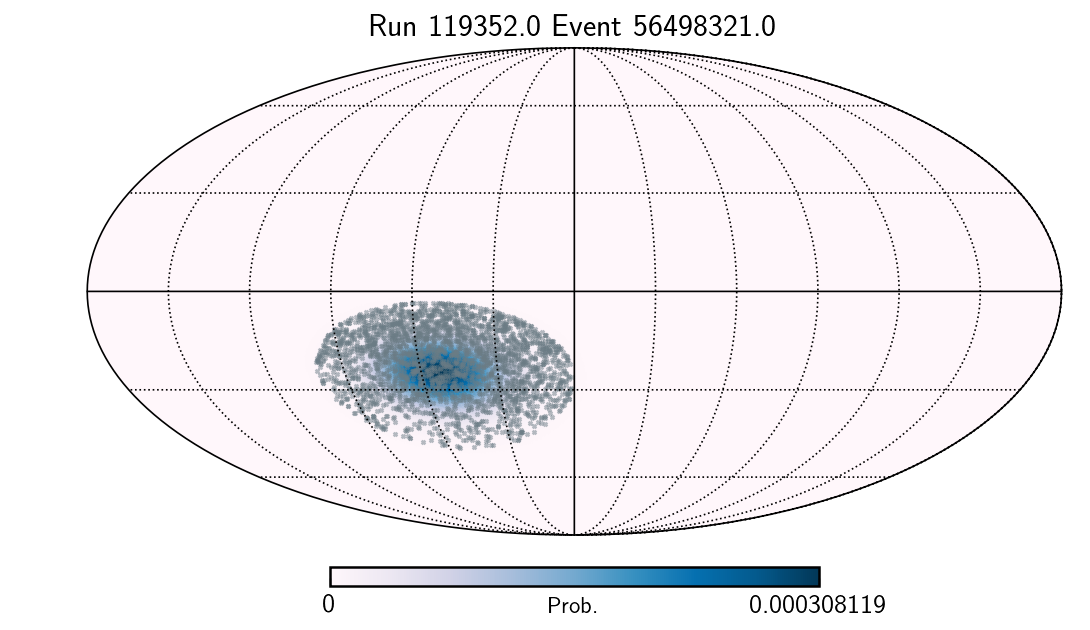

In [5]:
casc_calc = sff.CascadeCalculator(1000.)
casc_calc.plot_map_with_bg_scatter(8)

/mnt/lfs7/user/apizzuto/fast_response_skylab/alert_event_followup/cascade_scripts/sensitivity_fit_functions.py:345: RuntimeWarning: divide by zero encountered in log10
  skymap = np.log10(s)


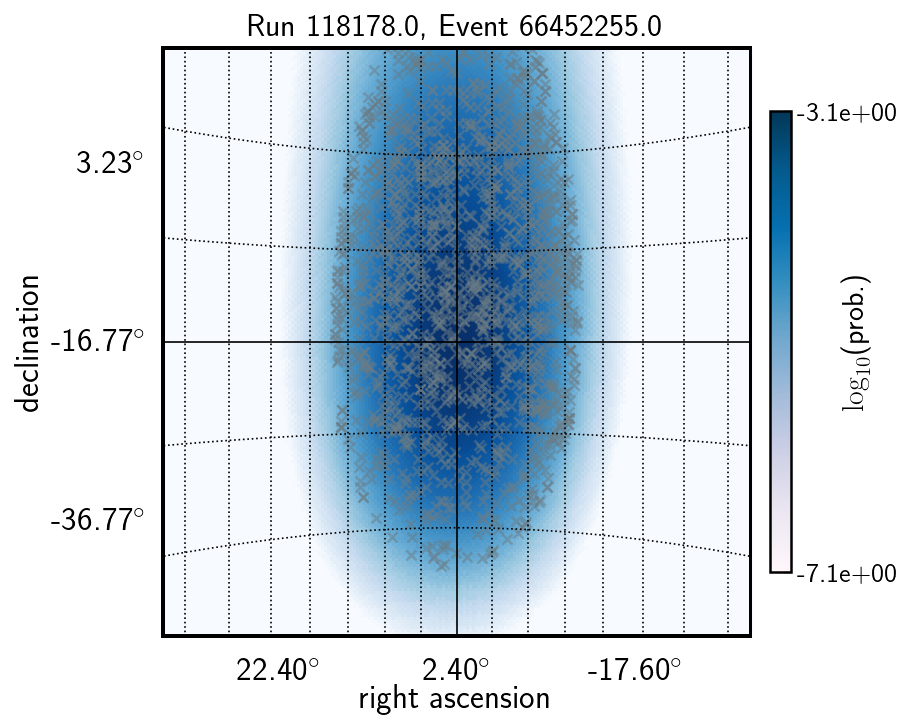

In [6]:
casc_calc = sff.CascadeCalculator(1000.)
casc_calc.plot_zoom_with_bg_scatter(0)

In [21]:
reload(sff)

<module 'sensitivity_fit_functions' from '/mnt/lfs7/user/apizzuto/fast_response_skylab/alert_event_followup/cascade_scripts/sensitivity_fit_functions.py'>

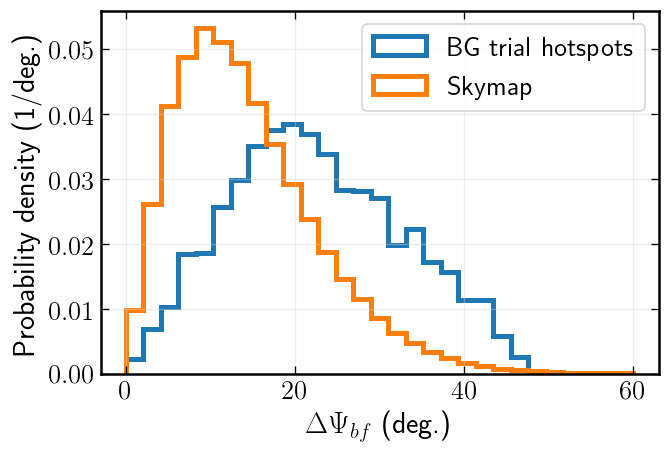

In [22]:
casc_calc = sff.CascadeCalculator(1000.)
casc_calc.background_opening_angle_psf(8)

# DO this for opening angle for simulation between true injection and reco

In [ ]:
def deltaPsi(dec1, ra1, dec2, ra2):
    return deltaPsi2(np.sin(dec1), np.cos(dec1), np.sin(ra1), np.cos(ra1), np.sin(dec2), np.cos(dec2), np.sin(ra2), np.cos(ra2))

def deltaPsi2(sDec1, cDec1, sRa1, cRa1, sDec2, cDec2, sRa2, cRa2):
    tmp = cDec1*cRa1*cDec2*cRa2 + cDec1*sRa1*cDec2*sRa2 + sDec1*sDec2
    tmp[tmp>1.] = 1.
    tmp[tmp<-1.] = -1.
    return np.arccos(tmp)

In [ ]:
delta_t = 1000.
ind = 4
for ninj in np.linspace(1, 5, 2).astype(int):
    casc_calc = sff.CascadeCalculator(delta_t)
    signal = casc_calc.signal_distribution(ind, ninj)
    inj_ra, inj_dec = signal['true_ra'], signal['true_dec']
    reco_ra, reco_dec = signal['ra'], signal['dec']
    del_psi = deltaPsi(reco_dec, reco_ra, inj_dec, inj_ra)
    del_psi *= 180. / np.pi
    plt.hist(del_psi, bins=np.linspace(0., 3., 21), histtype='step', lw=2., 
             density=True, label = r'$n_{\mathrm{inj}}=$' + str(ninj))
plt.ylabel(r'prob. density (deg.$^{-1}$)')
plt.xlabel(r'$\Delta \Psi$ (source, reco)')
plt.legend(loc=1)
plt.show()

In [ ]:
plt.close()